**Nama: Muhammad Al Fikri**  
**Asal Instansi: STT Terpadu Nurul Fikri**  
**Grup SIB: M04**  

*Dataset yang digunakan di proyek ini:*  
https://drive.google.com/file/d/12xgfvhXSob6we2dPho69u89vwbZjs6KM/view?usp=sharing

In [356]:
# impor semua library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from sklearn import preprocessing

In [357]:
# Upload dataset yang dibutuhkan
from google.colab import files
files.upload()

Saving usd-price.csv to usd-price.csv


{'usd-price.csv': b'date,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume\r\n2021-01-30,128437.248512,34246.28,131012.7232,34933.0,123106.88,32825.0,128333.212416,34218.54,43072\r\n2021-01-29,125144.022272,33368.18,144510.03776,38531.9,119695.51616,31915.4,128459.45088,34252.2,231827\r\n2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.81184,29842.1,125131.570944,33364.86,92621\r\n2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.20896,30366.15,95911\r\n2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972\r\n2021-01-25,120985.84128,32259.45,130795.2,34875.0,119675.264,31910.0,120966.15168,32254.2,88499\r\n2021-01-24,120305.3312,32078.0,124029.4784,33071.0,115887.36,30900.0,120987.52896,32259.9,57978\r\n2021-01-23,123575.68,32950.0,125473.3824,33456.0,117725.656064,31390.16,120305.3312,32078.0,64595\r\n2021-01-22,115707.303296,30851.99,126863.018112,33

In [358]:
# Membaca dataset
df = pd.read_csv('usd-price.csv', parse_dates=['date'])

In [359]:
# Menghapus kolom yang tidak digunakan
df = df.drop(['open_SAR', 
              'open_USD', 
              'high_SAR', 
              'low_SAR', 
              'high_USD', 
              'close_SAR', 
              'low_USD', 
              'volume'], 
             axis='columns')

In [360]:
# Menampilkan isi dataset
df

,date,close_USD
0,2021-01-30,34218.54
1,2021-01-29,34252.20
2,2021-01-28,33364.86
3,2021-01-27,30366.15
4,2021-01-26,32467.77
...,...,...
996,2018-05-10,9002.20
997,2018-05-09,9310.00
998,2018-05-08,9187.56
999,2018-05-07,9365.00


In [361]:
# Menampilkan informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1001 non-null   datetime64[ns]
 1   close_USD  1001 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


In [362]:
# Memastikan setiap kolom dalam dataset tidak ada yang kosong
df.isnull().sum()

date         0
close_USD    0
dtype: int64

In [363]:
# Melakukan pelabelan data
data_train = df.values
X = data_train[:,0:1] #Atribut
Y = data_train[:,1:2] #Label
data_train

array([[Timestamp('2021-01-30 00:00:00'), 34218.54],
       [Timestamp('2021-01-29 00:00:00'), 34252.2],
       [Timestamp('2021-01-28 00:00:00'), 33364.86],
       ...,
       [Timestamp('2018-05-08 00:00:00'), 9187.56],
       [Timestamp('2018-05-07 00:00:00'), 9365.0],
       [Timestamp('2018-05-06 00:00:00'), 9385.0]], dtype=object)

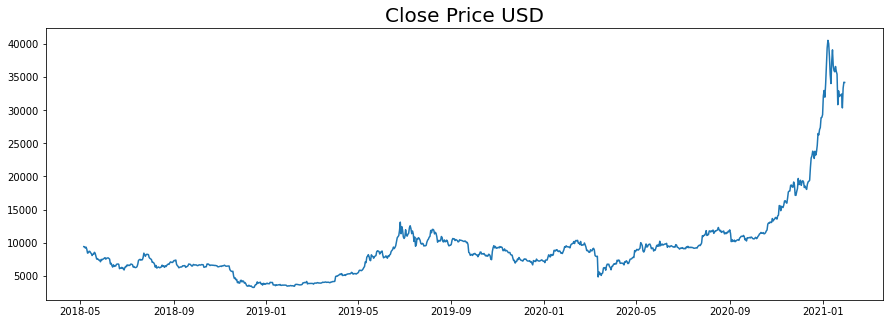

In [364]:
# Menampilkan grafik dataset
dates = df['date'].values
price  = df['close_USD'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, price)
plt.title('Close Price USD',
          fontsize=20);

In [365]:
# Mengubah dataset menjadi format yang dapat diterima model
def windowed_dataset(series, shuffle_buffer, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [366]:
# Normalisasi data
min_max_scaler = preprocessing.MinMaxScaler()
Y_scale = min_max_scaler.fit_transform(Y)

In [367]:
# Melakukan splitting data
train_date, test_date, train_price, test_price = train_test_split(X, Y_scale, test_size=0.2)

train_set = windowed_dataset(train_price, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(test_price, window_size=60, batch_size=100, shuffle_buffer=1000)

In [368]:
# Membuat model
model = Sequential([
  LSTM(60, input_shape=(360,1)),
  Dropout(0.2),
  Dense(100, activation="relu"),
  Dense(30, activation="relu"),
  Dense(1),
])

In [369]:
# Membuat fitur callback
minMAE = 0.1
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')< minMAE):
      print('\nNilai minimum MAE telah tercapai, proses dihentikan!')
      self.model.stop_training = True

callbacks = myCallback()

In [370]:
# Menambahkan optimizer
optimizer = SGD(learning_rate=1.0000e-03, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [371]:
# Melakukan training data
history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=callbacks)

Epoch 1/100
8/8 [==============================] - 3s 83ms/step - loss: 0.0252 - mae: 0.1635 - val_loss: 0.0276 - val_mae: 0.1639
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0225 - mae: 0.1470 - val_loss: 0.0241 - val_mae: 0.1478
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0195 - mae: 0.1289 - val_loss: 0.0214 - val_mae: 0.1280
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0172 - mae: 0.1165 - val_loss: 0.0194 - val_mae: 0.1155
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0156 - mae: 0.1031 - val_loss: 0.0180 - val_mae: 0.1035
Epoch 6/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0145 - mae: 0.0970
Nilai minimum MAE telah tercapai, proses dihentikan!
8/8 [==============================] - 0s 17ms/step - loss: 0.0144 - mae: 0.0967 - val_loss: 0.0169 - val_mae: 0.1039


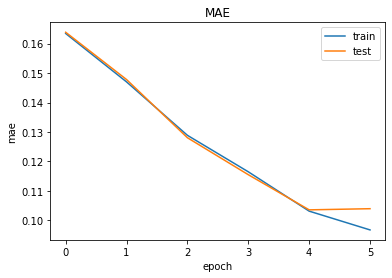

In [372]:
# Menampilkan plotting MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

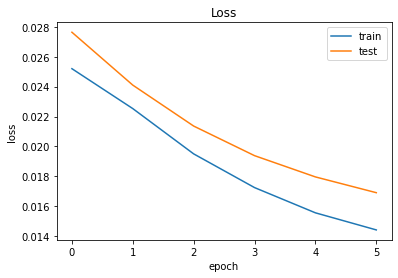

In [373]:
# Menampilkan plotting Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()